<a href="https://colab.research.google.com/github/TJConnellyContingentMacro/NU422/blob/master/Connelly_Terrence_Assignment_3_Boston_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluating Regression Models using Boston Housing Study**

Use all explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study. 

Use one of two response variables: (1) **the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars.** 

Employ** at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, ridge regression, lasso regression, and elastic net. **

Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. Python scikit-learn should be your primary environment for conducting this research. Note that it is not necessary to employ polynomial regression in this assignment.

 The objective of the study was to examine
the effect of air pollution on housing prices, controlling for the
effects of other explanatory variables. The response variable
is the median price of homes in the census track. Table 1
shows variables included in the case. Short variable names
correspond to those used in previously published studies.

Regarding the management problem, imagine that you are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. Of the modeling methods examined in your study, which would you recommend to management, and why?


### **Useful references I found while doing this:**

https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

####  Libraries and Modules Used

In [0]:
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
%matplotlib inline

import seaborn as sns  # pretty plotting, including heat map
plt.style.use('fivethirtyeight')

# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.png', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)


from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# BernoulliNB is designed for binary/boolean features
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_auc_score   
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import SGDRegressor

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.regressor import ManualAlphaSelection
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

from sklearn.pipeline import Pipeline



from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)




import warnings
warnings.filterwarnings("ignore")

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

import os

PROJECT_ROOT_DIR = ""
CHAPTER_ID = ""

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

print("All Packages and a Correlation Chart function loaded.  WARNING - this was created in April, 2019 and warnings were supressed.")

All Packages and a Correlation Chart function loaded.  WARNING - this was created in April, 2019 and warnings were supressed.


# Ingest

In [0]:
bos = pd.read_csv('https://github.com/GoPackers/NU422/raw/GoPackers-NU422-Wk3-Boston-Hsg-and-Regression/boston.csv')  
# examine the shape of original input data
print(bos.shape)
print(bos.dropna().shape)
bos = bos.drop(['neighborhood'], axis = 1)

(506, 14)
(506, 14)


# Exploratory Data Analysis

In [0]:
bos.head()


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2



**mv** Median value of homes in thousands of 1970 dollars    **nox** Air pollution (nitrogen oxide concentration)

**crim** Crime rate **zn** Percent of land zoned for lots  **indus** Percent of business that is industrial or nonretail

**chas** On the Charles River (1) or not (0)  **rooms** Average number of rooms per home

**age** Percentage of homes built before 1940  **dis** Weighted distance to employment centers

**rad** Accessibility to radial highways  **tax** Tax rate

**ptratio** Pupil/teacher ratio in public schools  **lstat** Percentage of population of lower socio-economic status

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5814d4a470>,
      dtype=object)

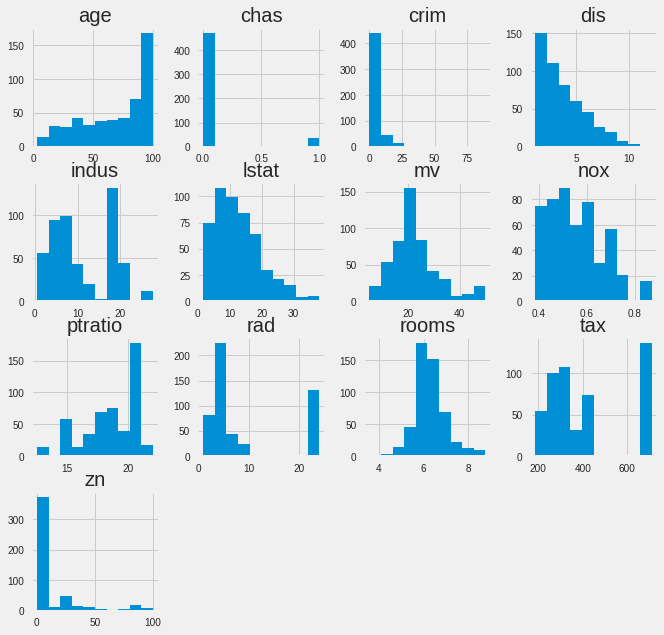

In [0]:
bos.hist(bins = 10,figsize=(10,10))

# Research Design and Modeling Methods

### Now let's plot the potential independent/explanatory variables against our response variable, home values (home value on x-axis).



*   We see good potential fit with rooms and "lstat", the percentage of lower socioeconomic households in the area. 
*   there is a small relationship with zoning and "ptratio", the pupil to student ratios at the nearby schools.   


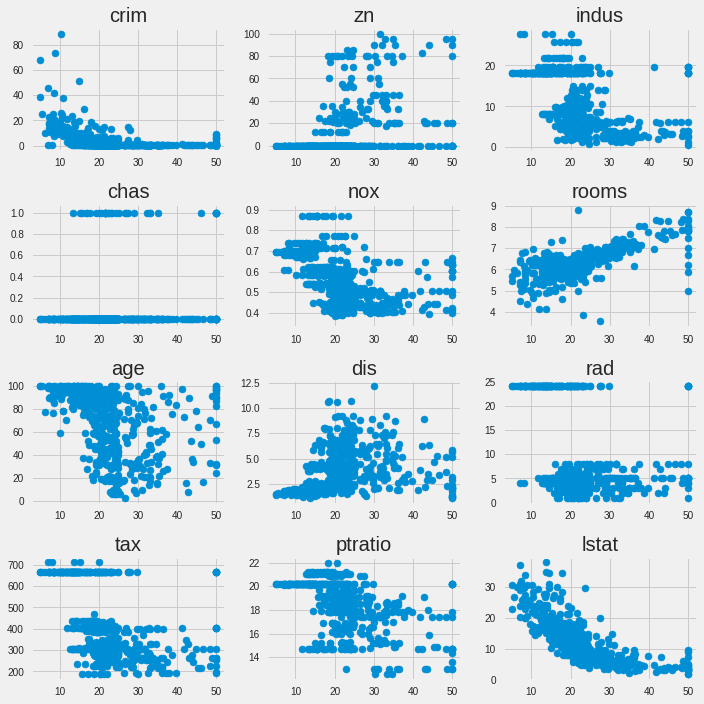

In [0]:
#@title
fig = plt.figure(figsize = (10,10))
columns = 3
rows = 4
for i in range(len(bos.columns)-1):
           plt.subplot(rows, columns, i+1)
           plt.scatter(bos['mv'], bos.iloc[:,i:i+1])
           plt.title(bos.columns[i])
plt.tight_layout()
plt.show()


***There appears to be an outlier or possible "plug" figure at 49k in market value.  Let's drop datapoints greater than or equal to 49k.  There are only 16, so dataset will now be 490. And then we'll plot again**

In [0]:
bos.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


In [0]:
bos[bos['mv']>=49].count()


crim       16
zn         16
indus      16
chas       16
nox        16
rooms      16
age        16
dis        16
rad        16
tax        16
ptratio    16
lstat      16
mv         16
dtype: int64

## Evaluate and remove outliers, ultimately cut dataset down to 358

In [0]:
bos2 = bos[(bos['mv'] < 49)]
bos2.describe()


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.520000,12.92402,21.631837
std,8.722154,22.844626,6.821302,0.236209,0.116688,0.653147,28.16479,2.109948,8.691297,168.065190,2.110478,7.08318,7.846800
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.90000,1.137000,1.000000,187.000000,12.600000,1.98000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.881000,44.55000,2.111050,4.000000,280.250000,17.400000,7.34750,16.700000
50%,0.247510,0.000000,9.690000,0.000000,0.538000,6.185000,76.80000,3.275900,5.000000,330.000000,19.100000,11.67500,20.900000
75%,3.647422,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.200000,17.11750,24.600000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.000000,37.97000,48.800000


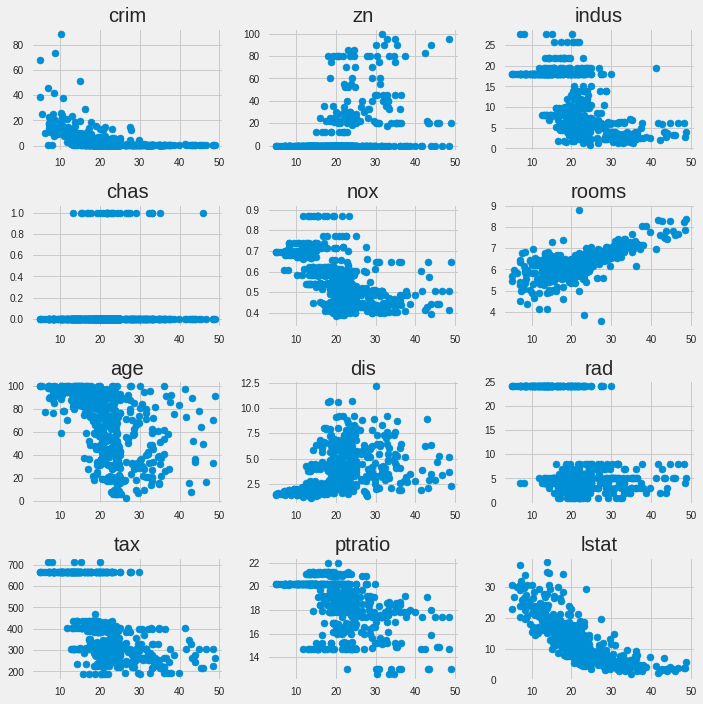

In [0]:

fig = plt.figure(figsize = (10,10))
columns = 3
rows = 4
for i in range(len(bos2.columns)-1):
           plt.subplot(rows, columns, i+1)
           plt.scatter(bos2['mv'], bos2.iloc[:,i:i+1])
           plt.title(bos2.columns[i])
plt.tight_layout()
plt.show()

In [0]:
bos2 = bos[(bos['mv'] < 49) & (bos['rad'] <= 24) & (bos['tax'] < 600)]
bos2.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,0.376563,15.209497,8.402346,0.067039,0.511169,6.335726,60.377095,4.479447,4.452514,312.245810,17.901955,10.622123,24.091899
std,0.620910,25.541107,5.926865,0.250440,0.101593,0.606355,28.209364,2.102061,1.643843,67.303451,2.163090,5.794361,7.148455
min,0.006320,0.000000,0.740000,0.000000,0.385000,4.903000,2.900000,1.321600,1.000000,187.000000,12.600000,1.980000,11.800000
25%,0.060543,0.000000,4.050000,0.000000,0.437225,5.926250,35.950000,2.742600,4.000000,270.000000,16.600000,6.360000,19.400000
50%,0.130875,0.000000,6.660000,0.000000,0.493000,6.218500,61.900000,4.090250,4.000000,304.000000,18.100000,9.500000,22.600000
75%,0.350705,22.000000,10.010000,0.000000,0.544000,6.635000,87.375000,5.957925,5.000000,380.500000,19.200000,13.495000,27.400000
max,4.097400,100.000000,25.650000,1.000000,0.871000,8.398000,100.000000,12.126500,8.000000,469.000000,22.000000,34.410000,48.800000


# Modelling and Analysis

<Figure size 432x288 with 0 Axes>

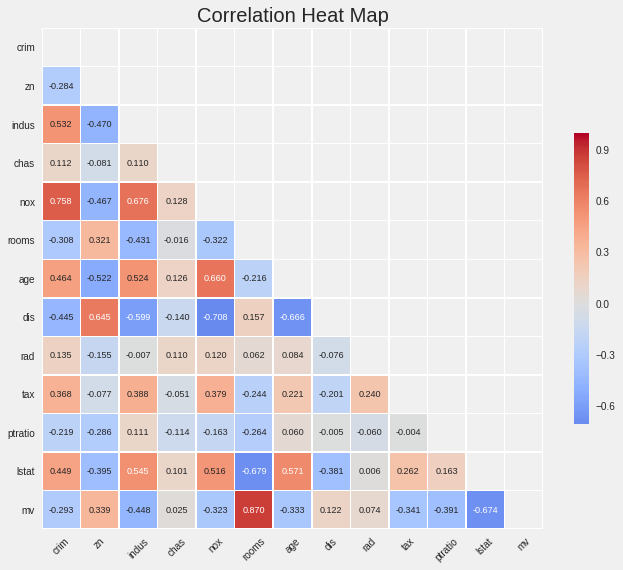

In [0]:
corr_chart(bos2)  

**Now create matrix and convert market value to log**

In [0]:
# set up preliminary data for data for fitting the models 
# the first column is the log median housing value response
# the raemaining columns are the explanatory variables
prelim_model_data = np.array([np.log(bos2.mv),\
   bos2.crim,\
    bos2.zn,\
    bos2.indus,\
    bos2.chas,\
    bos2.nox,\
    bos2.rooms,\
    bos2.age,\
    bos2.dis,\
    bos2.rad,\
    bos2.tax,\
    bos2.ptratio,\
    bos2.lstat]).T

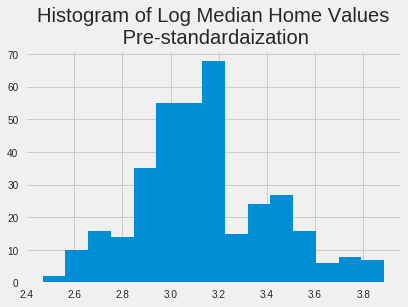

In [0]:
plt.hist(prelim_model_data[:,0], bins = 'auto')
plt.title('Histogram of Log Median Home Values\n Pre-standardaization')
plt.savefig('Hist-Log-Median-Home-Values.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)
plt.show()

**I didn't find it necessary to scalethe logged data, but this is code for scaling if I had:**

scaler = StandardScaler()



## Linear Regression Model - Log Mean Market Values vs. Rooms in Home

In [0]:
X = prelim_model_data[:,0].reshape(-1,1)

y = prelim_model_data[:,6].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=11)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(array([0.518]), array([[1.854]]))

In [0]:
y_pred = lin_reg.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,6.373,6.332145
1,7.014,6.867619
2,7.820,7.526596
3,6.302,6.471868
4,6.151,5.856886


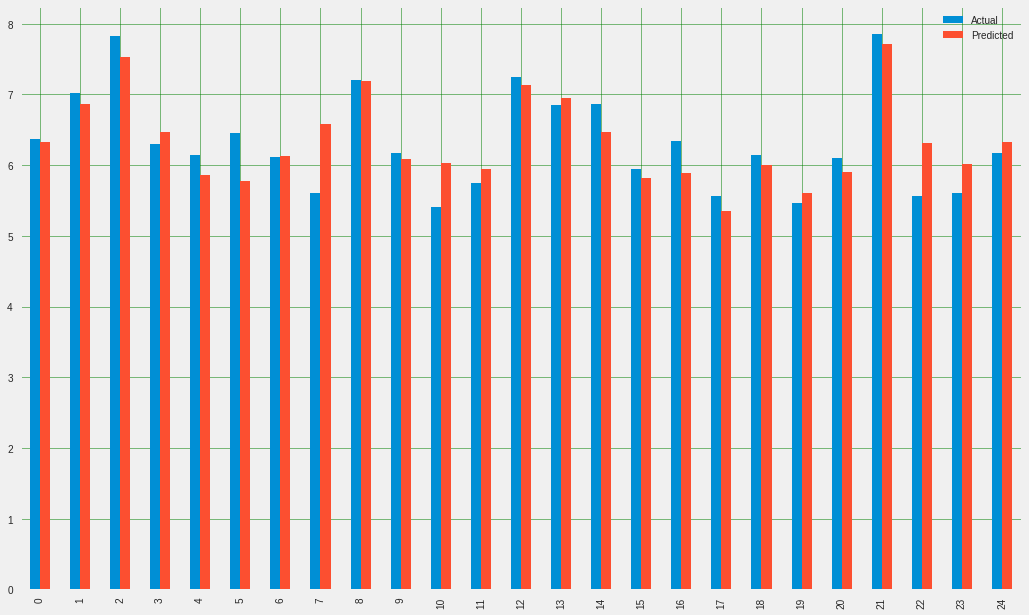

In [0]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

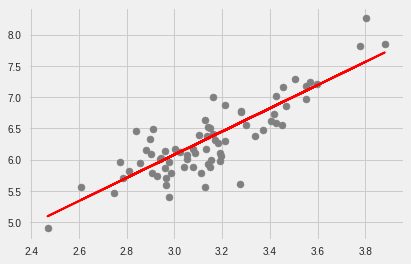

In [0]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [0]:

print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2)) 
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 0.25
Mean Squared Error: 0.1
Root Mean Squared Error: 0.32


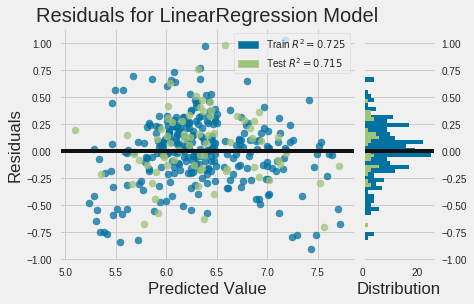

In [0]:

visualizer = ResidualsPlot(lin_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

## Ridge Regression Model -  Log Mean Market Values vs. Rooms in Home


Ridge regression use a regularization paramenter Alpha -- here let's run through the results with different parameters.  As the "alpha" regularization gets very largee the regularization effect dominates the square loss function and the coeffeicients tend towards zero.   
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

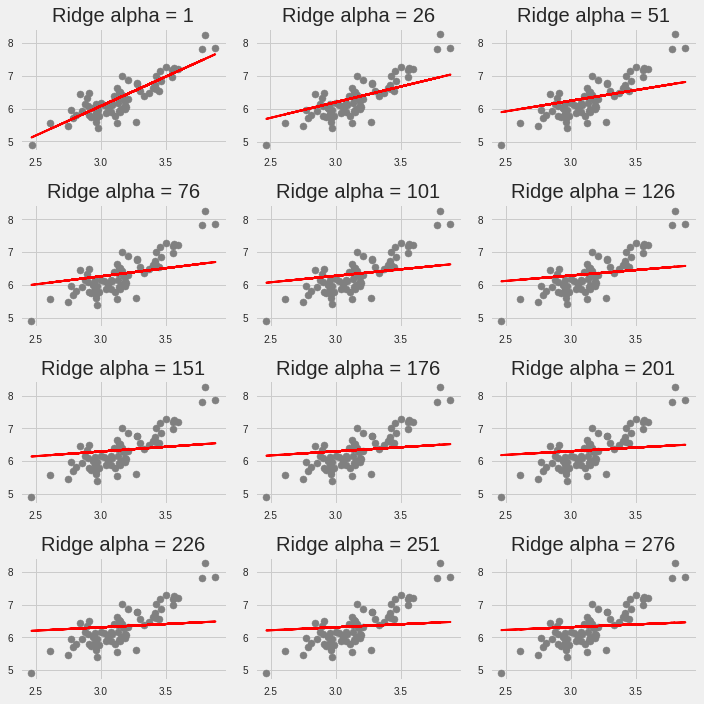

In [0]:


fig = plt.figure(figsize = (10,10))
columns = 3
rows = 4
count = 0

for i in range(1, 301, 25):
  ridge_reg = Ridge(alpha=i, solver="cholesky")
  ridge_reg.fit(X, y)
  y_pred_Ridge = ridge_reg.predict(X_test)
  plt.subplot(rows, columns, count+1)
  plt.scatter(X_test, y_test,  color='gray')
  plt.plot(X_test, y_pred_Ridge, color='red', linewidth=2)
  plt.title('Ridge alpha = ' + str(i))
  plt.tight_layout()
  count = count+1

            

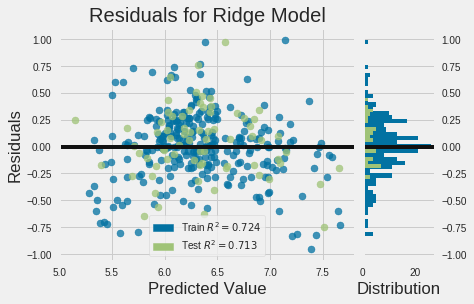

In [0]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
visualizer = ResidualsPlot(ridge_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()


Saving figure ridge_regression_plot


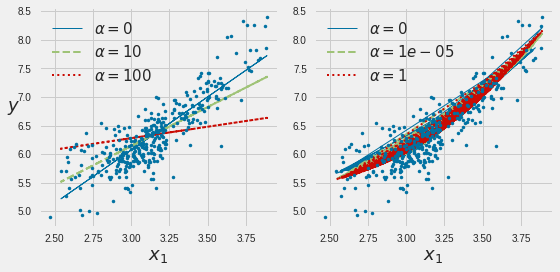

In [0]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])

        
        model.fit(X, y)
        y_new_regul = model.predict(X_train)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_train, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    #plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

## Lasso Regression

-0.0026700320377290865

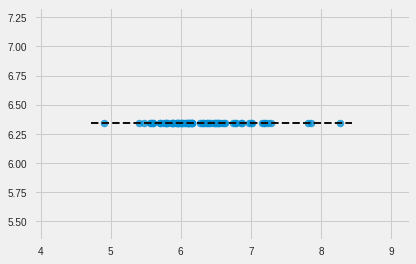

In [0]:
model = Lasso()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test) 

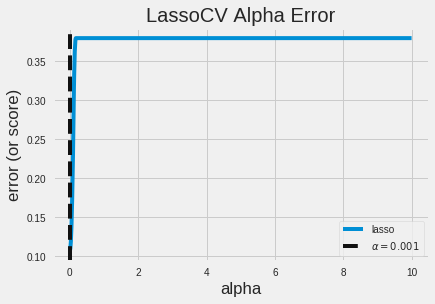

In [0]:
alphas = np.logspace(-10, 1, 400)
model = LassoCV(alphas=alphas, cv=3)
visualizer = AlphaSelection(model)

visualizer.fit(X, y)              # Fit the data to the visualizer
visualizer.poof()   

In [0]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.423])

Saving figure early_stopping_plot


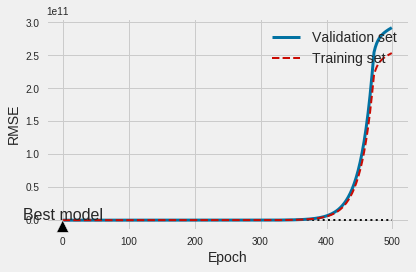

In [0]:
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_test_poly_scaled = poly_scaler.transform(X_test)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_test_predict = sgd_reg.predict(X_test_poly_scaled)
    train_errors.append(metrics.mean_squared_error(y_train, y_train_predict))
    val_errors.append(metrics.mean_squared_error(y_test, y_test_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

#Conclusion & Management Recommendations


*   Management should consider using Linear and Ridge Regressions.  Overall both offer good predictability across variables with relatively low residuals.   

*  Careful consideration of the regularization parameter is necessary using the methods deployed in this study.   













